# Inclined ball-drop viscometer

Swetha Vutlapalli & Daniel Duke
Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
Department of Mechanical & Aerospace Engineering
Monash University, Australia

In [1]:
import numpy as np
from pandas import read_excel
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib notebook


### 1. Functions to solve
Finding the drag coefficient either from the drag force, or from the Reynolds number.


In [2]:
def Cd_from_force_balance(theta, U, friction_coeff, rhoL):
    '''
        theta: inclination angles (degrees)
        U: velocities (m/s)
        friction_coeff: Coefficient of friction (-)
        rhoL: density of the liquid (kg/m3)
    '''
    
    # given constants
    g=9.81 # m/s^2
    rhoBall = 7850. # kg/m^3
    D=1e-3 #m
    
    # calculated constants
    Vball = (4/3.)*np.pi*(D/2.)**3 # volume
    m = rhoBall*g*Vball
    S = 0.25*np.pi*(D**2) # projected area 
    
    # coefficients in equation
    thetaRad = np.array(theta)*(np.pi/180.)
    thetaTerm = np.sin(thetaRad) - friction_coeff*np.cos(thetaRad)
    dynamicPressureS = 0.5*rhoL*(np.array(U)**2)*S
    netWeight = g*(m-rhoL*Vball)
    
    # Parallel to the plane, net force:
    # m.a = netWeight*sin(theta) - Cd*dynamicPressureS - friction_coeff*netWeight*cos(theta)
    # Thus at equilibrium, Cd = netWeight*(sin(theta) - friction_coeff*cos(theta))/dynamicPressureS
    
    return thetaTerm*netWeight/dynamicPressureS
    


In [3]:
def Cd_from_Reynolds(viscosity,U,D=1e-3):
    '''
        viscosity: kinematic viscosity (m^2/s)
        U: velocities (m/s)
        D: diameter [m]
    '''
    
    Re = D*np.array(U)/viscosity

    # https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf
    Cd = (24./Re)
    Cd += (2.6*Re/5.)/(1+(Re/5.)**1.52)
    Cd += (0.411*(Re/2.63e5)**-7.94)/(1+(Re/2.63e5)**-8)
    Cd += (0.25*Re/1e6)/(1+(Re/1e6))
    
    Cd[Re>1e6] = np.nan # don't use for Re>1e6
    
    return Cd, Re

### 2. Residual functions

Allow friction coefficient to vary with inclination angle, Re.
For a given friction coefficient and viscosity, return the sum squared error in the drag coefficient estimate.

In [36]:
def ffriction(theta,param2,a,b,c,d,e,f):
    '''
        A guess for a function that can allow friction coefficient to vary if required
    '''
    t=theta*np.pi/180.
    fTheta = t*(a + b*t**-1.5)
    gRho = c/param2 + d
    return fTheta*gRho
    #return a + np.array(theta)*b + np.array(Re)*c
    #return a + np.array(theta)*b + (np.array(theta)**2)*c + (np.array(theta)**3)*d
    #return np.abs( a**(b*np.array(U)+c) )

In [6]:
def Cd_both(theta, U, friction, rhoL, viscosity):
    '''
        Return drag coefficient from both methods, with variable friction coefficient
    '''

    Cd1, Re = Cd_from_Reynolds(viscosity, U)
    
    friction_coeff = ffriction(theta, rhoL, *friction) 

    Cd2 = Cd_from_force_balance(theta, U, friction_coeff, rhoL )
    
    return Cd1, Cd2

In [7]:
def Cd_residual(stateVector, U, rhoL, theta ):
    # stateVector contains the unknown parameters : friction coefficient(s) and kinematic viscosity.
    friction, viscosity = stateVector
    
    Cd1, Cd2 = Cd_both(theta, U, friction, rhoL, viscosity)
    
    return np.sum(np.abs(Cd2-Cd1)**2)

### 3. Read Excel data for experiment

In [8]:
# Get the bottom-right table start at cell K9
R134_data = read_excel('Binary Mixture_velocities.xlsx', sheet_name="R134a_ethanol",\
                        skiprows=7, usecols="K:P").values

R152_data = read_excel('Binary Mixture_velocities.xlsx', sheet_name="R152a_ethanol",\
                        skiprows=7, usecols="K:P").values

R1234_data = read_excel('Binary Mixture_velocities.xlsx', sheet_name="R1234ze_ethanol",\
                        skiprows=7, usecols="K:P").values

### 4. For pure fluids of known viscosity, find the friction coefficient

In [9]:
# Get the data

# PURE R134a
theta_134 = [ float(th.split(' ')[0]) for th in R134_data[0][1:] ]
U_134 = R134_data[1][1:]
rhoL_134 = 1226.3
visc_134=0.00020805/rhoL_134

# PURE R152a
theta_152 = [ float(th.split(' ')[0]) for th in R152_data[0][1:] ]
U_152 = R134_data[1][1:]
rhoL_152 = 904. # approximate
visc_152= 0.000159/rhoL_152  # approximate

# PURE 1234ze
theta_1234 = [ float(th.split(' ')[0]) for th in R1234_data[0][1:] ]
U_1234 = R134_data[1][1:]
rhoL_1234 = 1170. # approximate
visc_1234= 0.000204/rhoL_1234  # approximate

# PURE Ethanol
theta_eth = theta_134
U_eth = R134_data[9][1:]
rhoL_eth = 789.56
visc_eth=0.0011994/rhoL_eth

# Combine the refrigerant data for a single solution
theta_all = np.concatenate((theta_134,theta_152,theta_1234,theta_eth))
U_all     = np.concatenate((U_134,U_152,U_1234,U_eth))
rhoL_all  = np.concatenate(((rhoL_134,)*len(theta_134),(rhoL_152,)*len(theta_152),(rhoL_1234,)*len(theta_1234),(rhoL_eth,)*len(theta_eth)))
visc_all  = np.concatenate(((visc_134,)*len(theta_134),(visc_152,)*len(theta_152),(visc_1234,)*len(theta_1234),(visc_eth,)*len(theta_eth)))

Reynolds_all=1e-3*np.array(U_all)/visc_all
print("Re =",Reynolds_all)

Re = [1303.8872737323825 1626.3040021778368 1978.4944377391328
 2178.0500954830336 2338.378780365888 1257.7153012781203
 1568.7149259566484 1908.433940546987 2100.9231298023433 2255.57441314047
 1268.7227653607536 1582.4442438601602 1925.1364629964644
 2119.310308417545 2275.3150923809303 88.96768888816798 111.62445990879561
 140.18893949044738 165.51668111271096 189.83588990150128]


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.15486451271943627
        x: [ 7.275e-01 -3.626e-03  1.199e+01  1.212e+00  0.000e+00
             0.000e+00]
      nit: 28
      jac: [ 5.240e-06  8.300e-05  1.863e-09  4.886e-06  0.000e+00
             0.000e+00]
 hess_inv: [[ 6.585e-03 -2.547e-04 ...  0.000e+00  0.000e+00]
            [-2.547e-04  2.225e-05 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 664
     njev: 93


<IPython.core.display.Javascript object>


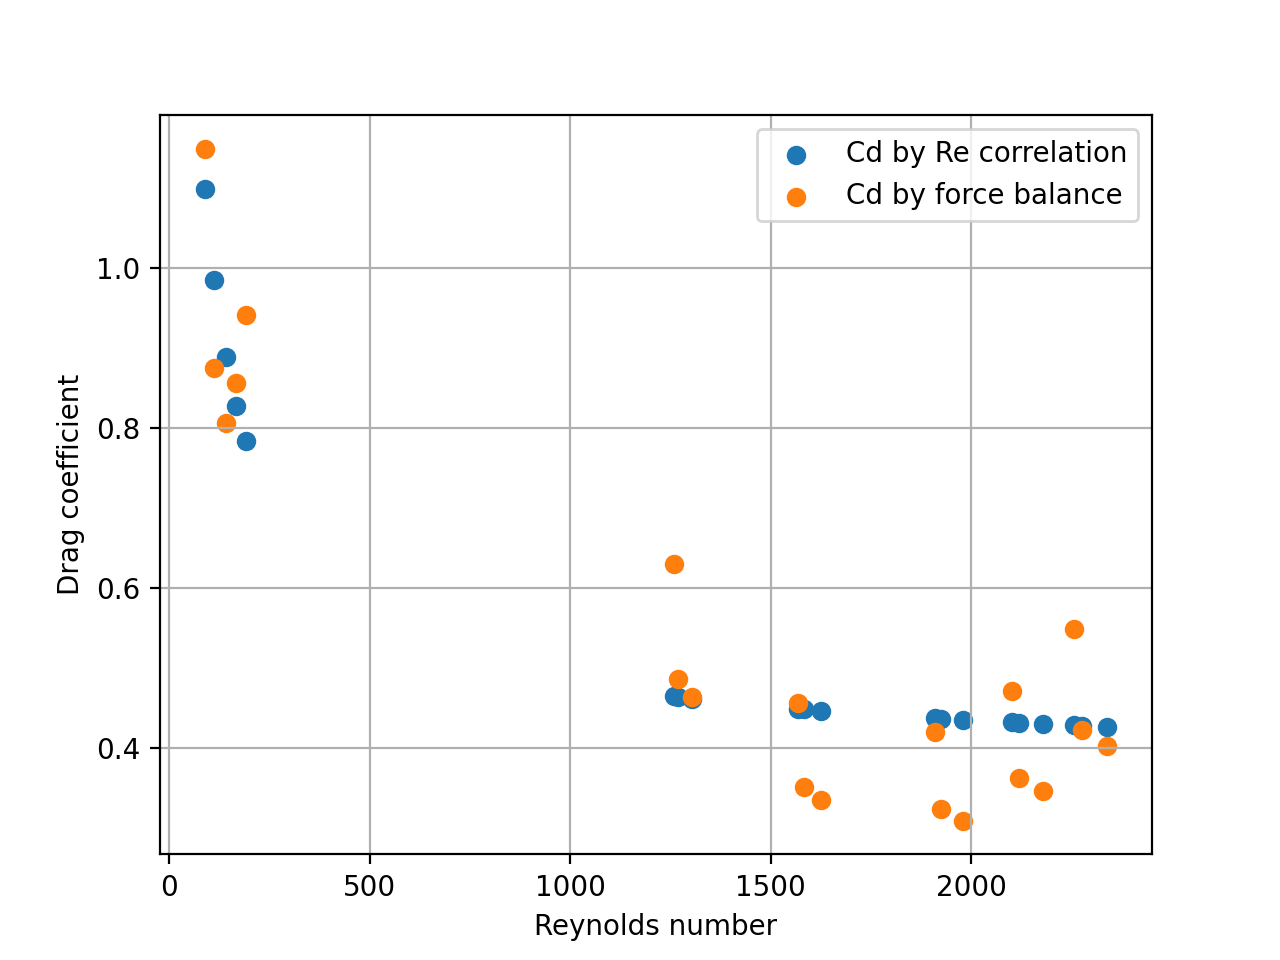

<IPython.core.display.Javascript object>


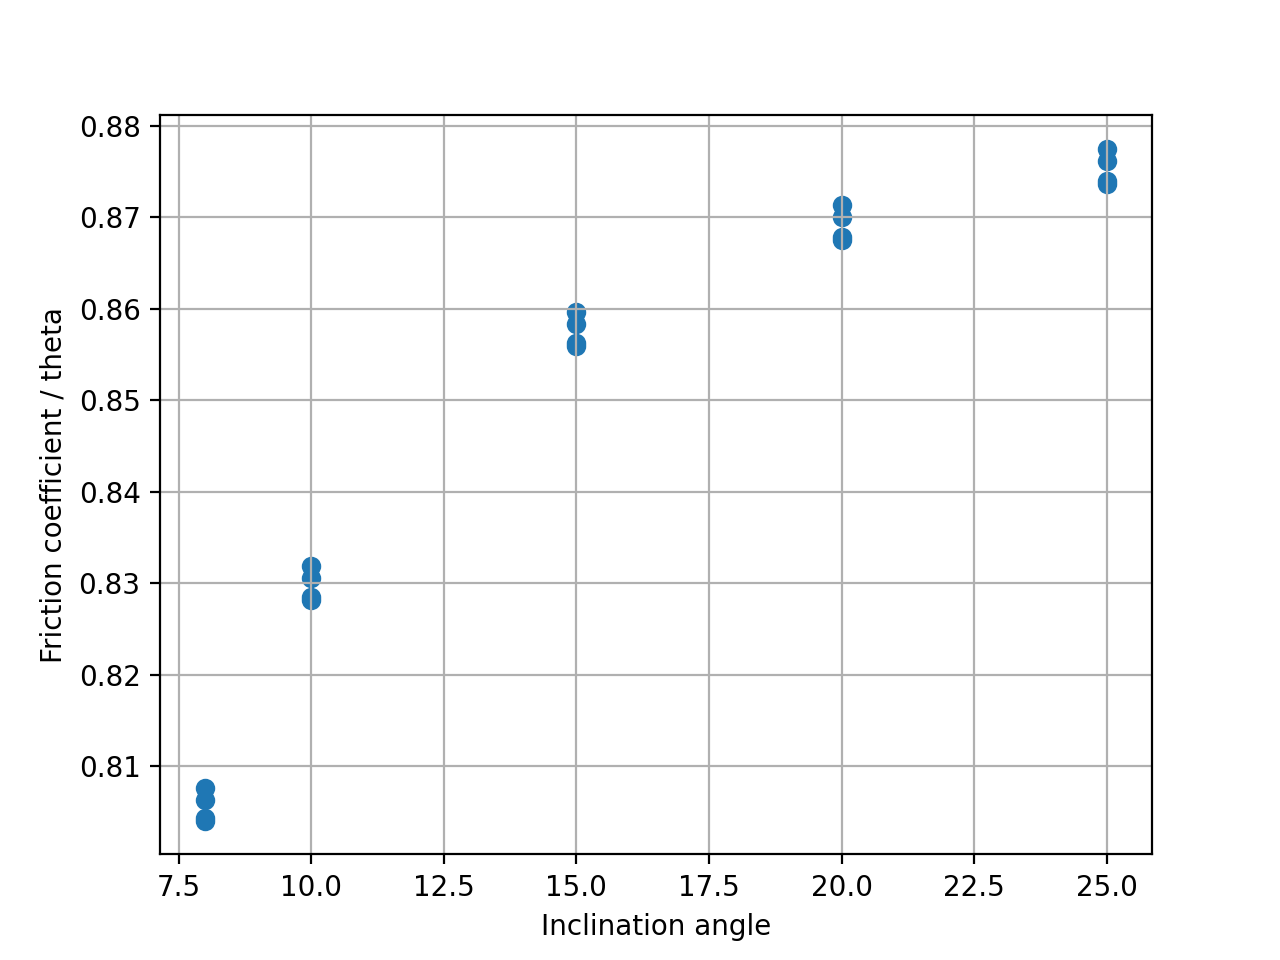

In [37]:
# Perform the calculation

# define an anonymous function that substitutes the known parameters and only depends on the unknown parameter.
# that unknown parameter in this case is the vector of friction coefficients.
myfun = lambda q:  Cd_residual((q, visc_all), U_all, rhoL_all, theta_all)

# Solve for minimising the drag coefficient residual by finding the friction coefficients between 0 and 1.
res = scipy.optimize.minimize(myfun, x0=(0.5,0,0,0,0,0))
friction = res.x
print(res)

Cd1, Cd2 = Cd_both(theta_all, U_all, friction, rhoL_all, visc_all)

plt.figure()
plt.grid()
plt.xlabel("Reynolds number")
plt.ylabel("Drag coefficient")
plt.scatter(Reynolds_all, Cd1, marker='o', label="Cd by Re correlation")
plt.scatter(Reynolds_all, Cd2, marker='o', label="Cd by force balance")
plt.legend();

plt.figure()
plt.grid()
plt.xlabel("Inclination angle")
plt.ylabel("Friction coefficient / theta")
plt.scatter(theta_all, ffriction(theta_all, rhoL_all, *friction)/(np.pi*theta_all/180.));
